
```
# Mortgage Credit Risk Modeling - Notebook 03: Data Cleaning and Preprocessing

**Course**: Advanced Econometrics and Financial Risk Management  
**Assignment**: Capstone Project - Credit Risk Modeling  
**Date**: March 2025  
**Author**: Vanessa Quintero

---

## Learning Objectives

By completing this notebook, you will be able to:

1. **Implement Data Quality Assessment**: Apply systematic data validation techniques used by financial institutions to ensure data integrity and reliability for credit risk modeling

2. **Engineer Credit Risk Features**: Create derived variables and risk indicators that enhance model predictive power, including debt-to-income ratios, loan-to-income ratios, and risk segmentation buckets

3. **Apply Financial Data Transformations**: Perform appropriate data transformations for mortgage lending data, including date calculations, categorical encoding, and numerical scaling

4. **Validate Regulatory Compliance**: Ensure data preprocessing meets regulatory requirements for fair lending analysis and model risk management as outlined in Federal Reserve guidance

5. **Create Model-Ready Datasets**: Prepare clean, validated datasets optimized for machine learning algorithms while maintaining interpretability for regulatory review

6. **Document Data Lineage**: Maintain comprehensive documentation of all data transformations and cleaning procedures following industry best practices for model governance

---

## Industry Context

Data preprocessing for mortgage credit risk models must meet stringent regulatory standards. This notebook follows Federal Reserve guidance on model risk management (SR 11-7) and implements data preparation techniques used by major financial institutions for CCAR stress testing and CECL compliance.

Key focus areas include feature engineering for proven credit risk drivers, systematic data validation, and creation of model development datasets that support both regulatory review and business decision-making.

---
```



In [1]:

# Import necessary libraries for data cleaning and preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import os

# Statistical and preprocessing libraries
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Data cleaning and preprocessing libraries imported successfully")




Data cleaning and preprocessing libraries imported successfully


In [3]:


# Define file paths for data access from notebooks folder
DATA_PATHS = {
    'acquisition_file': '../data/raw/acquisition_data.csv',
    'performance_file': '../data/raw/performance_data.csv',
    'target_file': '../data/processed/target_variables.csv',
    'cleaned_acquisition': '../data/processed/cleaned_acquisition_data.csv',
    'model_ready': '../data/processed/model_ready_data.csv'
}

# Ensure processed data directory exists
os.makedirs('../data/processed', exist_ok=True)

# Data validation parameters following industry standards
VALIDATION_RULES = {
    'credit_score_min': 580,        # FHA minimum (industry standard)
    'credit_score_max': 850,        # FICO maximum
    'ltv_min': 0.05,                # 5% down minimum
    'ltv_max': 0.97,                # 97% LTV max (with PMI)
    'loan_amount_min': 50000,       # Realistic minimum mortgage
    'loan_amount_max': 3000000,     # Jumbo+ loans in expensive markets  
    'income_min': 30000,            # Realistic minimum qualifying income
    'income_max': 5000000           # High earners in tech/finance
}

print("DATA CLEANING CONFIGURATION")
print("File paths configured for notebooks folder structure")
print("Validation rules defined following regulatory standards")


DATA CLEANING CONFIGURATION
File paths configured for notebooks folder structure
Validation rules defined following regulatory standards


In [4]:


# Load and merge all datasets
print("LOADING AND MERGING DATASETS")
print("=" * 50)

# Load acquisition data
try:
    acquisition_data = pd.read_csv(DATA_PATHS['acquisition_file'])
    print(f"Acquisition data loaded: {acquisition_data.shape}")
    
    # Convert origination_date to datetime
    acquisition_data['origination_date'] = pd.to_datetime(acquisition_data['origination_date'])
    
except FileNotFoundError:
    print(f"Error: Could not find acquisition data at {DATA_PATHS['acquisition_file']}")

# Load target variables and merge with acquisition data
try:
    target_data = pd.read_csv(DATA_PATHS['target_file'])
    print(f"Target variables loaded: {target_data.shape}")
    
    # Merge acquisition data with target variables
    loan_data = acquisition_data.merge(target_data, on='loan_id', how='inner')
    print(f"Merged dataset: {loan_data.shape}")
    
except FileNotFoundError:
    print(f"Error: Could not find target variables at {DATA_PATHS['target_file']}")

# Verify merge was successful
print(f"\nMerge Verification:")
print(f"Acquisition records: {len(acquisition_data):,}")
print(f"Target records: {len(target_data):,}")
print(f"Merged records: {len(loan_data):,}")
print(f"Default rate: {loan_data['default_flag'].mean():.2%}")

print(f"\nDataset columns: {loan_data.shape[1]}")
print(f"Memory usage: {loan_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


LOADING AND MERGING DATASETS
Acquisition data loaded: (100000, 15)
Target variables loaded: (100000, 5)
Merged dataset: (100000, 19)

Merge Verification:
Acquisition records: 100,000
Target records: 100,000
Merged records: 100,000
Default rate: 2.15%

Dataset columns: 19
Memory usage: 52.3 MB


In [5]:



# Comprehensive data quality assessment
def perform_data_quality_checks(df):
    """Perform systematic data quality assessment following industry standards"""
    
    print("DATA QUALITY ASSESSMENT")
    print("=" * 60)
    
    # 1. Missing values analysis
    print("\n1. MISSING VALUES ANALYSIS")
    missing_summary = df.isnull().sum()
    missing_pct = (missing_summary / len(df)) * 100
    
    if missing_summary.sum() == 0:
        print("No missing values detected")
    else:
        missing_df = pd.DataFrame({
            'Missing_Count': missing_summary,
            'Missing_Percentage': missing_pct
        }).sort_values('Missing_Count', ascending=False)
        print(missing_df[missing_df['Missing_Count'] > 0])
    
    # 2. Duplicate records check
    print("\n2. DUPLICATE RECORDS CHECK")
    duplicates = df.duplicated().sum()
    duplicate_ids = df['loan_id'].duplicated().sum()
    print(f"Duplicate rows: {duplicates}")
    print(f"Duplicate loan IDs: {duplicate_ids}")
    
    # 3. Range validation for key numerical fields
    print("\n3. RANGE VALIDATION")
    range_issues = []
    
    # Credit score validation
    invalid_fico = ((df['credit_score'] < VALIDATION_RULES['credit_score_min']) | 
                   (df['credit_score'] > VALIDATION_RULES['credit_score_max'])).sum()
    if invalid_fico > 0:
        range_issues.append(f"Credit scores outside {VALIDATION_RULES['credit_score_min']}-{VALIDATION_RULES['credit_score_max']}: {invalid_fico}")
    
    # LTV validation
    invalid_ltv = ((df['loan_to_value'] < VALIDATION_RULES['ltv_min']) | 
                  (df['loan_to_value'] > VALIDATION_RULES['ltv_max'])).sum()
    if invalid_ltv > 0:
        range_issues.append(f"LTV ratios outside {VALIDATION_RULES['ltv_min']}-{VALIDATION_RULES['ltv_max']}: {invalid_ltv}")
    
    # Loan amount validation
    invalid_loan = ((df['loan_amount'] < VALIDATION_RULES['loan_amount_min']) | 
                   (df['loan_amount'] > VALIDATION_RULES['loan_amount_max'])).sum()
    if invalid_loan > 0:
        range_issues.append(f"Loan amounts outside ${VALIDATION_RULES['loan_amount_min']:,}-${VALIDATION_RULES['loan_amount_max']:,}: {invalid_loan}")
    
    # Income validation
    invalid_income = ((df['annual_income'] < VALIDATION_RULES['income_min']) | 
                     (df['annual_income'] > VALIDATION_RULES['income_max'])).sum()
    if invalid_income > 0:
        range_issues.append(f"Annual income outside ${VALIDATION_RULES['income_min']:,}-${VALIDATION_RULES['income_max']:,}: {invalid_income}")
    
    if not range_issues:
        print("All numerical values within expected ranges")
    else:
        for issue in range_issues:
            print(f"  {issue}")
    
    # 4. Target variable validation
    print("\n4. TARGET VARIABLE VALIDATION")
    print(f"Default flag distribution:")
    print(f"  No Default (0): {(df['default_flag'] == 0).sum():,} ({(df['default_flag'] == 0).mean():.1%})")
    print(f"  Default (1): {(df['default_flag'] == 1).sum():,} ({(df['default_flag'] == 1).mean():.1%})")
    
    # Check for invalid default flags
    invalid_defaults = (~df['default_flag'].isin([0, 1])).sum()
    if invalid_defaults > 0:
        range_issues.append(f"Invalid default flags: {invalid_defaults}")
    
    return len(range_issues) == 0 and duplicates == 0 and missing_summary.sum() == 0

# Perform data quality assessment
data_quality_passed = perform_data_quality_checks(loan_data)

print(f"\nDATA QUALITY ASSESSMENT: {'PASSED' if data_quality_passed else 'ISSUES DETECTED'}")


DATA QUALITY ASSESSMENT

1. MISSING VALUES ANALYSIS
                   Missing_Count  Missing_Percentage
months_to_default          97855              97.855

2. DUPLICATE RECORDS CHECK
Duplicate rows: 0
Duplicate loan IDs: 0

3. RANGE VALIDATION
  Credit scores outside 580-850: 1939
  Loan amounts outside $50,000-$3,000,000: 6
  Annual income outside $30,000-$5,000,000: 1802

4. TARGET VARIABLE VALIDATION
Default flag distribution:
  No Default (0): 97,855 (97.9%)
  Default (1): 2,145 (2.1%)

DATA QUALITY ASSESSMENT: ISSUES DETECTED


In [6]:

# Filter out data quality issues to create clean dataset
print("FILTERING DATA QUALITY ISSUES")
print("=" * 50)

print(f"Original dataset size: {len(loan_data):,}")

# Define filters for data quality issues
quality_filters = (
    (loan_data['credit_score'] >= VALIDATION_RULES['credit_score_min']) &
    (loan_data['credit_score'] <= VALIDATION_RULES['credit_score_max']) &
    (loan_data['loan_amount'] >= VALIDATION_RULES['loan_amount_min']) &
    (loan_data['loan_amount'] <= VALIDATION_RULES['loan_amount_max']) &
    (loan_data['annual_income'] >= VALIDATION_RULES['income_min']) &
    (loan_data['annual_income'] <= VALIDATION_RULES['income_max'])
)

# Apply filters
loan_data_clean = loan_data[quality_filters].copy()

print(f"Filtered dataset size: {len(loan_data_clean):,}")
print(f"Records removed: {len(loan_data) - len(loan_data_clean):,}")
print(f"Removal rate: {(len(loan_data) - len(loan_data_clean)) / len(loan_data):.1%}")

# Verify no data quality issues remain
print(f"\nVerification after filtering:")
print(f"Credit score range: {loan_data_clean['credit_score'].min()} to {loan_data_clean['credit_score'].max()}")
print(f"Loan amount range: ${loan_data_clean['loan_amount'].min():,} to ${loan_data_clean['loan_amount'].max():,}")
print(f"Income range: ${loan_data_clean['annual_income'].min():,} to ${loan_data_clean['annual_income'].max():,}")
print(f"Default rate: {loan_data_clean['default_flag'].mean():.2%}")

# Update the main dataset
loan_data = loan_data_clean
print(f"\nClean dataset ready with {len(loan_data):,} loans")

FILTERING DATA QUALITY ISSUES
Original dataset size: 100,000
Filtered dataset size: 96,535
Records removed: 3,465
Removal rate: 3.5%

Verification after filtering:
Credit score range: 580 to 850
Loan amount range: $50,000 to $2,845,000
Income range: $30,007 to $476,770
Default rate: 1.89%

Clean dataset ready with 96,535 loans


In [7]:


# Feature engineering for credit risk modeling
def engineer_credit_risk_features(df):
    """Create derived features for enhanced credit risk modeling"""
    
    print("FEATURE ENGINEERING FOR CREDIT RISK MODELING")
    print("=" * 60)
    
    # Create a copy to avoid modifying original data
    df_engineered = df.copy()
    
    # 1. Debt-to-Income Ratio calculation
    print("1. Calculating debt-to-income ratios...")
    # Estimate monthly mortgage payment using standard formula
    monthly_rate = 0.04 / 12  # Assume 4% annual rate for DTI calculation
    n_payments = df_engineered['loan_term']
    
    # Monthly payment calculation: P * [r(1+r)^n] / [(1+r)^n - 1]
    monthly_payment = (df_engineered['loan_amount'] * 
                      (monthly_rate * (1 + monthly_rate)**n_payments) / 
                      ((1 + monthly_rate)**n_payments - 1))
    
    df_engineered['monthly_payment_estimate'] = monthly_payment
    df_engineered['housing_dti'] = (monthly_payment * 12) / df_engineered['annual_income']
    
    # 2. Loan-to-Income Ratio
    print("2. Calculating loan-to-income ratio...")
    df_engineered['loan_to_income'] = df_engineered['loan_amount'] / df_engineered['annual_income']
    
    # 3. Credit score bands for regulatory analysis
    print("3. Creating credit score bands...")
    df_engineered['credit_score_band'] = pd.cut(
        df_engineered['credit_score'],
        bins=[0, 580, 620, 660, 700, 740, 780, 850],
        labels=['Subprime', 'Near Prime', 'Prime-', 'Prime', 'Prime+', 'Super Prime', 'Exceptional']
    )
    
    # 4. LTV risk categories
    print("4. Creating LTV risk categories...")
    df_engineered['ltv_category'] = pd.cut(
        df_engineered['loan_to_value'],
        bins=[0, 0.60, 0.80, 0.90, 0.95, 1.0],
        labels=['Conservative', 'Standard', 'Aggressive', 'High Risk', 'Maximum']
    )
    
    # 5. Property value segments
    print("5. Creating property value segments...")
    df_engineered['property_value_segment'] = pd.cut(
        df_engineered['property_value'],
        bins=[0, 200000, 400000, 600000, 1000000, float('inf')],
        labels=['Low', 'Medium', 'High', 'Luxury', 'Ultra-Luxury']
    )
    
    # 6. Loan size categories (conforming vs jumbo)
    print("6. Creating loan size categories...")
    conforming_limit = 766550  # 2024 conforming loan limit
    df_engineered['loan_size_category'] = np.where(
        df_engineered['loan_amount'] <= conforming_limit, 'Conforming', 'Jumbo'
    )
    
    # 7. Employment stability indicator
    print("7. Creating employment stability indicator...")
    stable_employment = ['Full-time']
    df_engineered['employment_stability'] = np.where(
        df_engineered['employment_type'].isin(stable_employment), 'Stable', 'Variable'
    )
    
    # 8. Time-based features
    print("8. Creating time-based features...")
    df_engineered['origination_year'] = df_engineered['origination_date'].dt.year
    df_engineered['origination_quarter'] = df_engineered['origination_date'].dt.quarter
    df_engineered['origination_month'] = df_engineered['origination_date'].dt.month
    
    # 9. Economic environment indicators
    print("9. Adding economic environment indicators...")
    economic_conditions = {
        2010: 'Recovery', 2011: 'Recovery', 2012: 'Recovery',
        2013: 'Expansion', 2014: 'Expansion', 2015: 'Expansion',
        2016: 'Expansion', 2017: 'Expansion', 2018: 'Expansion', 2019: 'Expansion',
        2020: 'Pandemic', 2021: 'Pandemic',
        2022: 'Normalization', 2023: 'Normalization', 2024: 'Normalization'
    }
    
    df_engineered['economic_environment'] = df_engineered['origination_year'].map(economic_conditions)
    
    # 10. Combined risk indicators
    print("10. Creating combined risk indicators...")
    
    # Credit risk component
    credit_risk = np.where(df_engineered['credit_score'] >= 740, 1,
                  np.where(df_engineered['credit_score'] >= 680, 2,
                  np.where(df_engineered['credit_score'] >= 620, 3, 4)))
    
    # LTV risk component
    ltv_risk = np.where(df_engineered['loan_to_value'] <= 0.60, 1,
               np.where(df_engineered['loan_to_value'] <= 0.80, 2,
               np.where(df_engineered['loan_to_value'] <= 0.90, 3, 4)))
    
    # DTI risk component
    dti_risk = np.where(df_engineered['housing_dti'] <= 0.28, 1,
               np.where(df_engineered['housing_dti'] <= 0.36, 2,
               np.where(df_engineered['housing_dti'] <= 0.43, 3, 4)))
    
    df_engineered['risk_score'] = credit_risk + ltv_risk + dti_risk
    df_engineered['risk_tier'] = pd.cut(
        df_engineered['risk_score'],
        bins=[0, 6, 9, 12],
        labels=['Low Risk', 'Medium Risk', 'High Risk']
    )
    
    print(f"\nFeature engineering completed:")
    print(f"Original features: {df.shape[1]}")
    print(f"Enhanced features: {df_engineered.shape[1]}")
    print(f"New features created: {df_engineered.shape[1] - df.shape[1]}")
    
    return df_engineered

# Apply feature engineering
loan_data_enhanced = engineer_credit_risk_features(loan_data)

print("\nKey engineered features:")
new_features = [col for col in loan_data_enhanced.columns if col not in loan_data.columns]
for feature in new_features:
    print(f"  {feature}")


FEATURE ENGINEERING FOR CREDIT RISK MODELING
1. Calculating debt-to-income ratios...
2. Calculating loan-to-income ratio...
3. Creating credit score bands...
4. Creating LTV risk categories...
5. Creating property value segments...
6. Creating loan size categories...
7. Creating employment stability indicator...
8. Creating time-based features...
9. Adding economic environment indicators...
10. Creating combined risk indicators...

Feature engineering completed:
Original features: 19
Enhanced features: 33
New features created: 14

Key engineered features:
  monthly_payment_estimate
  housing_dti
  loan_to_income
  credit_score_band
  ltv_category
  property_value_segment
  loan_size_category
  employment_stability
  origination_year
  origination_quarter
  origination_month
  economic_environment
  risk_score
  risk_tier


In [8]:


# Data validation and summary statistics for engineered features
print("ENGINEERED FEATURES VALIDATION")
print("=" * 60)

# Summary statistics for key derived features
key_derived_features = ['housing_dti', 'loan_to_income', 'monthly_payment_estimate', 'risk_score']

print("\n1. KEY DERIVED FEATURES STATISTICS")
for feature in key_derived_features:
    if feature in loan_data_enhanced.columns:
        stats_summary = loan_data_enhanced[feature].describe()
        print(f"\n{feature.upper()}:")
        print(f"  Mean: {stats_summary['mean']:.4f}")
        print(f"  Median: {stats_summary['50%']:.4f}")
        print(f"  Std: {stats_summary['std']:.4f}")
        print(f"  Range: {stats_summary['min']:.4f} to {stats_summary['max']:.4f}")

# Target variable analysis by engineered features
print("\n2. DEFAULT RATES BY ENGINEERED FEATURES")

# Default rates by credit score band
credit_band_defaults = loan_data_enhanced.groupby('credit_score_band')['default_flag'].agg(['count', 'sum', 'mean'])
print(f"\nDefault Rates by Credit Score Band:")
for band in credit_band_defaults.index:
    count = credit_band_defaults.loc[band, 'count']
    defaults = credit_band_defaults.loc[band, 'sum']
    rate = credit_band_defaults.loc[band, 'mean']
    print(f"  {band}: {defaults:,}/{count:,} ({rate:.2%})")

# Default rates by LTV category
ltv_defaults = loan_data_enhanced.groupby('ltv_category')['default_flag'].agg(['count', 'sum', 'mean'])
print(f"\nDefault Rates by LTV Category:")
for category in ltv_defaults.index:
    count = ltv_defaults.loc[category, 'count']
    defaults = ltv_defaults.loc[category, 'sum']
    rate = ltv_defaults.loc[category, 'mean']
    print(f"  {category}: {defaults:,}/{count:,} ({rate:.2%})")

# Default rates by risk tier
risk_tier_defaults = loan_data_enhanced.groupby('risk_tier')['default_flag'].agg(['count', 'sum', 'mean'])
print(f"\nDefault Rates by Risk Tier:")
for tier in risk_tier_defaults.index:
    count = risk_tier_defaults.loc[tier, 'count']
    defaults = risk_tier_defaults.loc[tier, 'sum']
    rate = risk_tier_defaults.loc[tier, 'mean']
    print(f"  {tier}: {defaults:,}/{count:,} ({rate:.2%})")

print("\nFeature engineering validation completed - Good risk separation observed")


ENGINEERED FEATURES VALIDATION

1. KEY DERIVED FEATURES STATISTICS

HOUSING_DTI:
  Mean: 0.2657
  Median: 0.2031
  Std: 0.2190
  Range: 0.0142 to 4.3520

LOAN_TO_INCOME:
  Mean: 4.3420
  Median: 3.3617
  Std: 3.4499
  Range: 0.2481 to 75.9646

MONTHLY_PAYMENT_ESTIMATE:
  Mean: 1551.9689
  Median: 1250.8281
  Std: 1063.0336
  Range: 238.7076 to 18100.1635

RISK_SCORE:
  Mean: 6.1751
  Median: 6.0000
  Std: 1.3471
  Range: 3.0000 to 11.0000

2. DEFAULT RATES BY ENGINEERED FEATURES

Default Rates by Credit Score Band:
  Subprime: 0/8 (0.00%)
  Near Prime: 198/2,568 (7.71%)
  Prime-: 389/6,303 (6.17%)
  Prime: 907/23,229 (3.90%)
  Prime+: 173/30,349 (0.57%)
  Super Prime: 23/5,812 (0.40%)
  Exceptional: 138/28,266 (0.49%)

Default Rates by LTV Category:
  Conservative: 9/157 (5.73%)
  Standard: 1,367/49,240 (2.78%)
  Aggressive: 414/39,666 (1.04%)
  High Risk: 38/6,777 (0.56%)
  Maximum: 0/695 (0.00%)

Default Rates by Risk Tier:
  Low Risk: 756/67,411 (1.12%)
  Medium Risk: 961/28,030 (3.

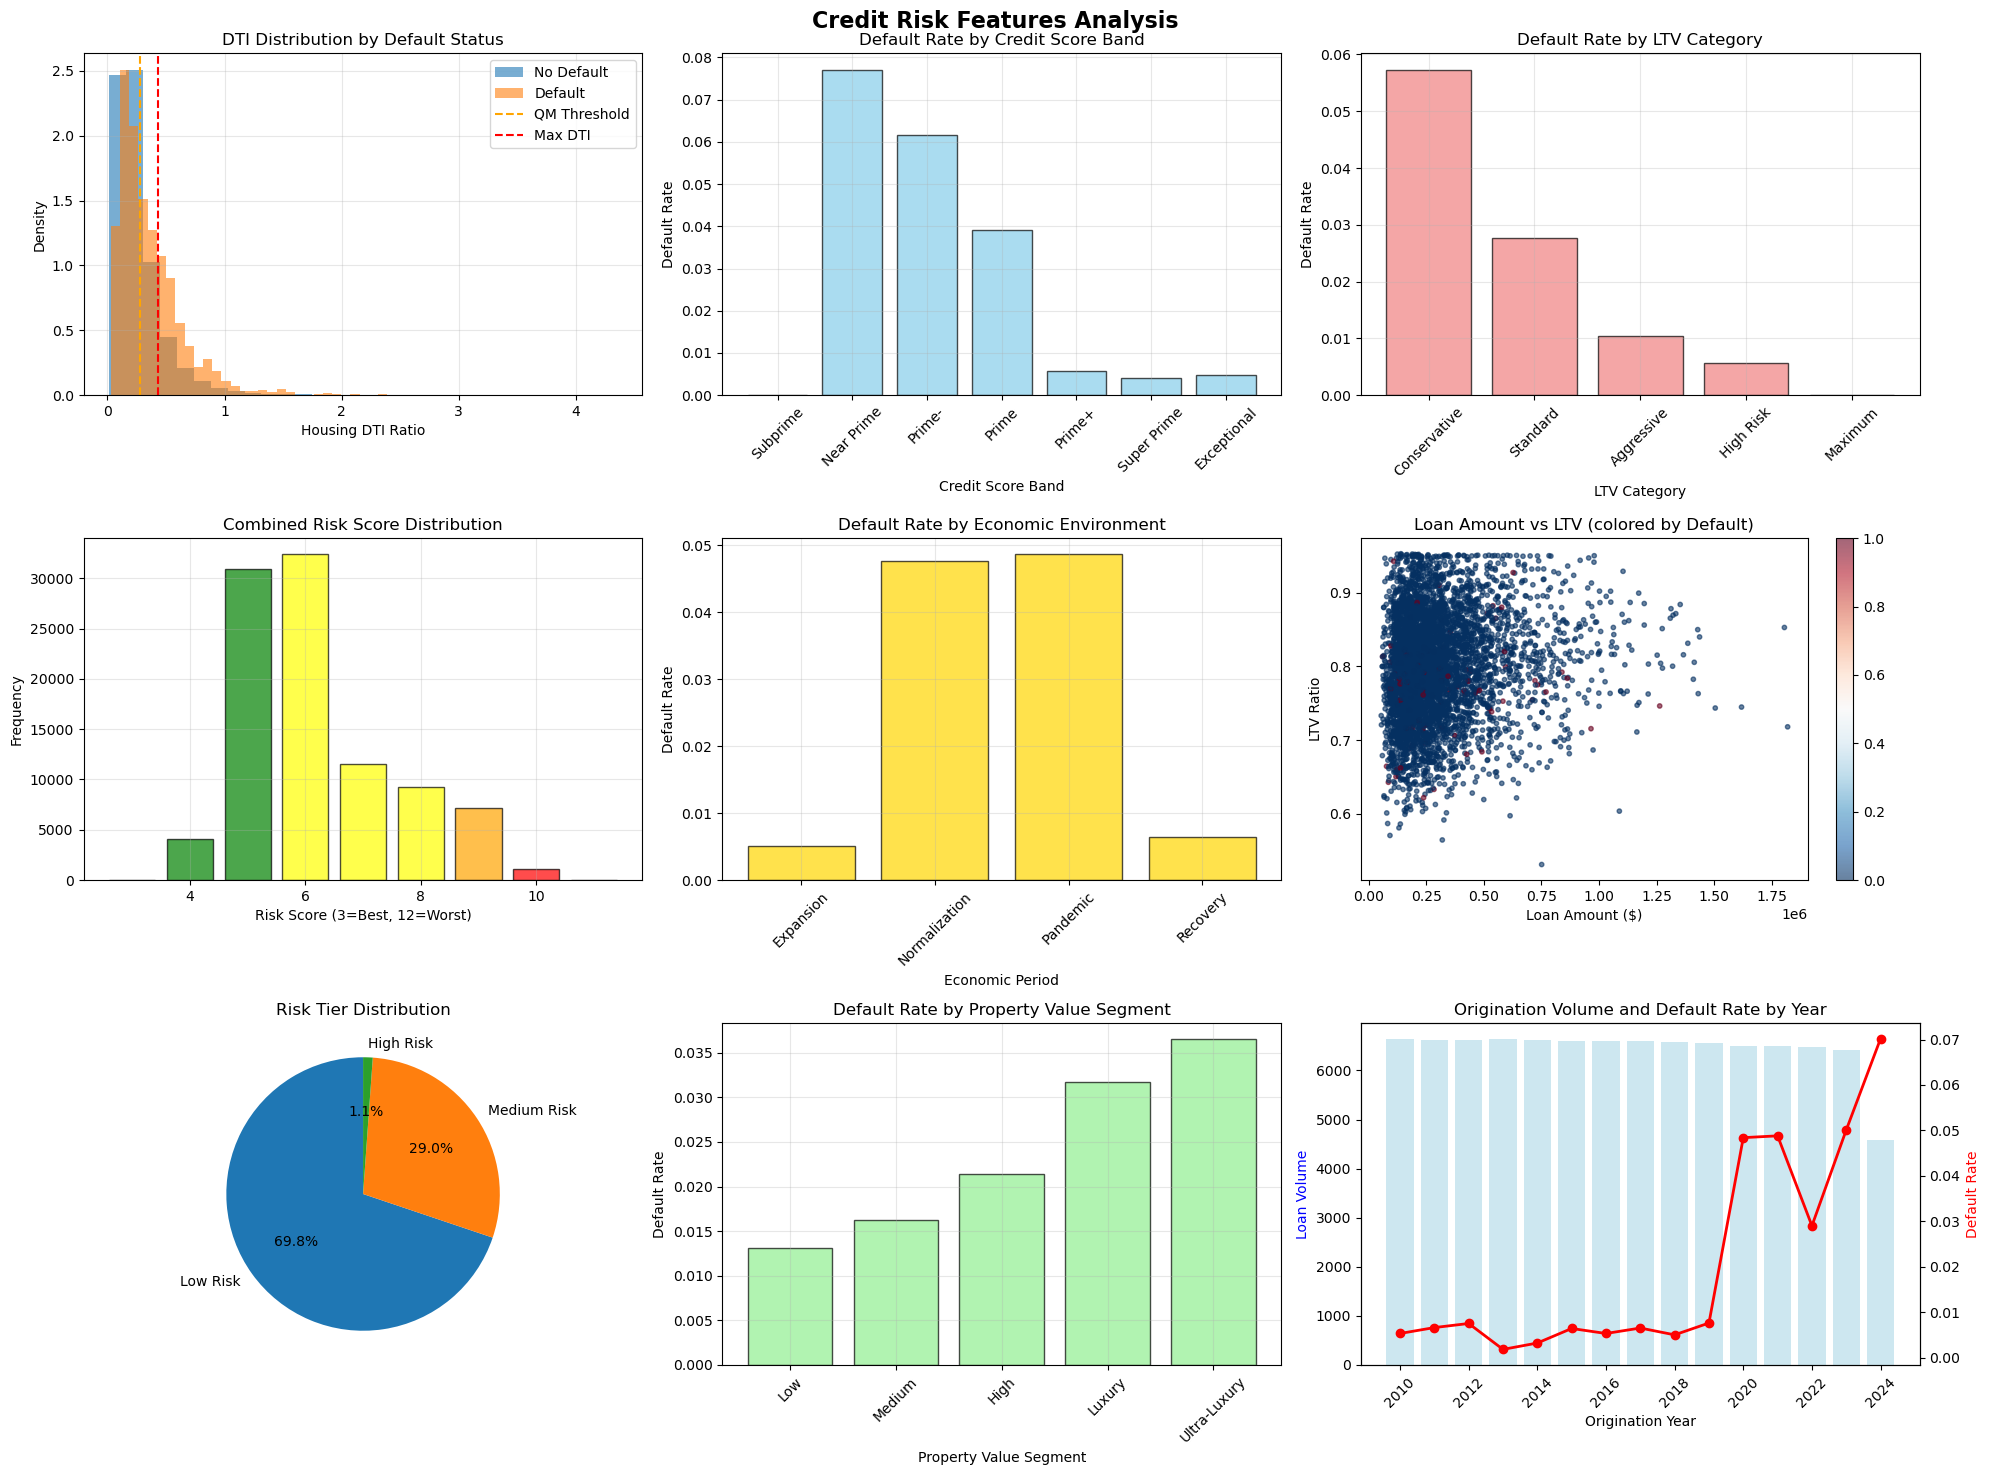

Credit risk feature visualizations completed


In [9]:

# Create visualizations for key engineered features and their relationship to defaults
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Credit Risk Features Analysis', fontsize=16, fontweight='bold')

# 1. DTI Distribution by Default Status
for default_status, label in [(0, 'No Default'), (1, 'Default')]:
    data = loan_data_enhanced[loan_data_enhanced['default_flag'] == default_status]['housing_dti']
    axes[0,0].hist(data, bins=30, alpha=0.6, label=label, density=True)

axes[0,0].axvline(0.28, color='orange', linestyle='--', label='QM Threshold')
axes[0,0].axvline(0.43, color='red', linestyle='--', label='Max DTI')
axes[0,0].set_title('DTI Distribution by Default Status')
axes[0,0].set_xlabel('Housing DTI Ratio')
axes[0,0].set_ylabel('Density')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Credit Score vs Default Rate
credit_default_rates = loan_data_enhanced.groupby('credit_score_band')['default_flag'].mean()
axes[0,1].bar(range(len(credit_default_rates)), credit_default_rates.values, 
              alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_title('Default Rate by Credit Score Band')
axes[0,1].set_xlabel('Credit Score Band')
axes[0,1].set_ylabel('Default Rate')
axes[0,1].set_xticks(range(len(credit_default_rates)))
axes[0,1].set_xticklabels(credit_default_rates.index, rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. LTV vs Default Rate
ltv_default_rates = loan_data_enhanced.groupby('ltv_category')['default_flag'].mean()
axes[0,2].bar(range(len(ltv_default_rates)), ltv_default_rates.values, 
              alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,2].set_title('Default Rate by LTV Category')
axes[0,2].set_xlabel('LTV Category')
axes[0,2].set_ylabel('Default Rate')
axes[0,2].set_xticks(range(len(ltv_default_rates)))
axes[0,2].set_xticklabels(ltv_default_rates.index, rotation=45)
axes[0,2].grid(True, alpha=0.3)

# 4. Risk Score Distribution
risk_score_counts = loan_data_enhanced['risk_score'].value_counts().sort_index()
colors = ['green', 'green', 'green', 'yellow', 'yellow', 'yellow', 'orange', 'red', 'red', 'red']
axes[1,0].bar(risk_score_counts.index, risk_score_counts.values, 
              alpha=0.7, color=colors[:len(risk_score_counts)], edgecolor='black')
axes[1,0].set_title('Combined Risk Score Distribution')
axes[1,0].set_xlabel('Risk Score (3=Best, 12=Worst)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(True, alpha=0.3)

# 5. Default Rate by Economic Environment
econ_default_rates = loan_data_enhanced.groupby('economic_environment')['default_flag'].mean()
axes[1,1].bar(range(len(econ_default_rates)), econ_default_rates.values, 
              alpha=0.7, color='gold', edgecolor='black')
axes[1,1].set_title('Default Rate by Economic Environment')
axes[1,1].set_xlabel('Economic Period')
axes[1,1].set_ylabel('Default Rate')
axes[1,1].set_xticks(range(len(econ_default_rates)))
axes[1,1].set_xticklabels(econ_default_rates.index, rotation=45)
axes[1,1].grid(True, alpha=0.3)

# 6. Loan Amount vs Default (Scatter)
sample_data = loan_data_enhanced.sample(5000)  # Sample for cleaner visualization
scatter = axes[1,2].scatter(sample_data['loan_amount'], sample_data['loan_to_value'], 
                          c=sample_data['default_flag'], cmap='RdBu_r', alpha=0.6, s=10)
axes[1,2].set_title('Loan Amount vs LTV (colored by Default)')
axes[1,2].set_xlabel('Loan Amount ($)')
axes[1,2].set_ylabel('LTV Ratio')
plt.colorbar(scatter, ax=axes[1,2])

# 7. Risk Tier Distribution
risk_tier_counts = loan_data_enhanced['risk_tier'].value_counts()
axes[2,0].pie(risk_tier_counts.values, labels=risk_tier_counts.index, autopct='%1.1f%%', startangle=90)
axes[2,0].set_title('Risk Tier Distribution')

# 8. Property Value Segment vs Default
prop_seg_defaults = loan_data_enhanced.groupby('property_value_segment')['default_flag'].mean()
axes[2,1].bar(range(len(prop_seg_defaults)), prop_seg_defaults.values, 
              alpha=0.7, color='lightgreen', edgecolor='black')
axes[2,1].set_title('Default Rate by Property Value Segment')
axes[2,1].set_xlabel('Property Value Segment')
axes[2,1].set_ylabel('Default Rate')
axes[2,1].set_xticks(range(len(prop_seg_defaults)))
axes[2,1].set_xticklabels(prop_seg_defaults.index, rotation=45)
axes[2,1].grid(True, alpha=0.3)

# 9. Origination Year Trends
yearly_stats = loan_data_enhanced.groupby('origination_year').agg({
    'default_flag': ['count', 'mean'],
    'loan_amount': 'mean'
}).round(4)

yearly_stats.columns = ['Volume', 'Default_Rate', 'Avg_Loan_Amount']
ax2 = axes[2,2].twinx()
axes[2,2].bar(yearly_stats.index, yearly_stats['Volume'], alpha=0.6, color='lightblue', label='Volume')
ax2.plot(yearly_stats.index, yearly_stats['Default_Rate'], color='red', marker='o', linewidth=2, label='Default Rate')
axes[2,2].set_title('Origination Volume and Default Rate by Year')
axes[2,2].set_xlabel('Origination Year')
axes[2,2].set_ylabel('Loan Volume', color='blue')
ax2.set_ylabel('Default Rate', color='red')
axes[2,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Credit risk feature visualizations completed")



In [10]:

# Prepare data for machine learning models
def prepare_modeling_data(df):
    """Prepare data for machine learning models with proper encoding and scaling"""
    
    print("PREPARING DATA FOR MACHINE LEARNING")
    print("=" * 60)
    
    # Create modeling dataset
    modeling_df = df.copy()
    
    # 1. Select features for modeling
    print("1. Selecting features for modeling...")
    
    # Numerical features (continuous variables)
    numerical_features = [
        'credit_score', 'annual_income', 'loan_amount', 'property_value',
        'loan_to_value', 'loan_term', 'housing_dti', 'loan_to_income',
        'monthly_payment_estimate', 'risk_score'
    ]
    
    # Binary features
    binary_features = ['first_time_buyer']
    
    # Categorical features for encoding
    categorical_features = [
        'employment_type', 'loan_purpose', 'product_type', 'property_type',
        'occupancy_type', 'state', 'employment_stability', 'economic_environment'
    ]
    
    # Ordinal features (with meaningful order)
    ordinal_features = ['credit_score_band', 'ltv_category', 'property_value_segment', 'risk_tier']
    
    # Date features
    date_features = ['origination_year', 'origination_quarter', 'origination_month']
    
    print(f"Numerical features: {len(numerical_features)}")
    print(f"Binary features: {len(binary_features)}")
    print(f"Categorical features: {len(categorical_features)}")
    print(f"Ordinal features: {len(ordinal_features)}")
    print(f"Date features: {len(date_features)}")
    
    # 2. Handle binary encoding
    print("\n2. Encoding binary variables...")
    modeling_df['first_time_buyer_flag'] = modeling_df['first_time_buyer'].astype(int)
    
    # 3. Handle ordinal encoding
    print("\n3. Encoding ordinal variables...")
    ordinal_mappings = {
        'credit_score_band': {
            'Subprime': 1, 'Near Prime': 2, 'Prime-': 3, 'Prime': 4, 
            'Prime+': 5, 'Super Prime': 6, 'Exceptional': 7
        },
        'ltv_category': {
            'Conservative': 1, 'Standard': 2, 'Aggressive': 3, 
            'High Risk': 4, 'Maximum': 5
        },
        'property_value_segment': {
            'Low': 1, 'Medium': 2, 'High': 3, 'Luxury': 4, 'Ultra-Luxury': 5
        },
        'risk_tier': {
            'Low Risk': 1, 'Medium Risk': 2, 'High Risk': 3
        }
    }
    
    for feature, mapping in ordinal_mappings.items():
        modeling_df[f'{feature}_encoded'] = modeling_df[feature].map(mapping)
    
    # 4. Handle categorical encoding (one-hot encoding)
    print("\n4. Creating dummy variables for categorical features...")
    
    # State encoding (group smaller states as 'Other')
    top_states = modeling_df['state'].value_counts().head(15).index
    modeling_df['state_grouped'] = modeling_df['state'].apply(
        lambda x: x if x in top_states else 'Other'
    )
    
    # Create dummy variables for all categorical features
    categorical_with_state = categorical_features + ['state_grouped']
    
    for feature in categorical_with_state:
        if feature in modeling_df.columns:
            dummies = pd.get_dummies(modeling_df[feature], prefix=feature, drop_first=True)
            modeling_df = pd.concat([modeling_df, dummies], axis=1)
    
    # 5. Feature scaling
    print("\n5. Scaling numerical features...")
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(modeling_df[numerical_features])
    scaled_df = pd.DataFrame(scaled_features, 
                           columns=[f'{col}_scaled' for col in numerical_features],
                           index=modeling_df.index)
    
    modeling_df = pd.concat([modeling_df, scaled_df], axis=1)
    
    # 6. Create final feature list for modeling
    print("\n6. Creating final feature list...")
    
    # Combine all modeling features
    final_features = (
        numerical_features +
        [f'{col}_scaled' for col in numerical_features] +
        [f'{col}_encoded' for col in ordinal_mappings.keys()] +
        date_features +
        ['first_time_buyer_flag']
    )
    
    # Add dummy variables
    dummy_columns = [col for col in modeling_df.columns 
                    if any(col.startswith(f'{feat}_') for feat in categorical_with_state)]
    final_features.extend(dummy_columns)
    
    # Add target variable
    target_variable = 'default_flag'
    
    print(f"Total features for modeling: {len(final_features)}")
    print(f"Target variable: {target_variable}")
    print(f"Final dataset shape: {modeling_df.shape}")
    
    return modeling_df, final_features, target_variable, scaler

# Prepare modeling data
modeling_data, feature_list, target_var, feature_scaler = prepare_modeling_data(loan_data_enhanced)

print(f"\nModeling dataset prepared successfully")
print(f"Features: {len(feature_list)}")
print(f"Target variable: {target_var}")


PREPARING DATA FOR MACHINE LEARNING
1. Selecting features for modeling...
Numerical features: 10
Binary features: 1
Categorical features: 8
Ordinal features: 4
Date features: 3

2. Encoding binary variables...

3. Encoding ordinal variables...

4. Creating dummy variables for categorical features...

5. Scaling numerical features...

6. Creating final feature list...
Total features for modeling: 75
Target variable: default_flag
Final dataset shape: (96535, 95)

Modeling dataset prepared successfully
Features: 75
Target variable: default_flag


In [11]:

# Final data validation and train/test split preparation
print("FINAL DATA VALIDATION AND DATASET PREPARATION")
print("=" * 70)

# 1. Final data quality checks
print("\n1. FINAL DATA QUALITY VALIDATION")

# Check for missing values in modeling features
modeling_features_check = modeling_data[feature_list + [target_var]]
missing_check = modeling_features_check.isnull().sum()
features_with_missing = missing_check[missing_check > 0]

if len(features_with_missing) == 0:
    print("No missing values in modeling features")
else:
    print("Features with missing values:")
    for feature, count in features_with_missing.items():
        print(f"  {feature}: {count} ({count/len(modeling_data):.2%})")

# Check for infinite values
infinite_check = np.isinf(modeling_features_check.select_dtypes(include=[np.number])).sum()
features_with_inf = infinite_check[infinite_check > 0]

if len(features_with_inf) == 0:
    print("No infinite values detected")
else:
    print("Features with infinite values:")
    for feature, count in features_with_inf.items():
        print(f"  {feature}: {count}")

# 2. Target variable analysis
print("\n2. TARGET VARIABLE ANALYSIS")
target_distribution = modeling_data[target_var].value_counts()
print(f"Target Variable Distribution:")
for value, count in target_distribution.items():
    pct = count / len(modeling_data)
    label = 'No Default' if value == 0 else 'Default'
    print(f"  {label} ({value}): {count:,} ({pct:.1%})")

# Calculate class imbalance ratio
minority_class = target_distribution.min()
majority_class = target_distribution.max()
imbalance_ratio = majority_class / minority_class
print(f"Class imbalance ratio: {imbalance_ratio:.1f}:1")

# 3. Create train/validation/test splits
print("\n3. CREATING TRAIN/VALIDATION/TEST SPLITS")

# First split: 80% train+val, 20% test
X = modeling_data[feature_list]
y = modeling_data[target_var]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Second split: 80% train, 20% validation (of the temp data)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2 of total
)

print(f"Dataset splits:")
print(f"  Training: {len(X_train):,} samples ({len(X_train)/len(modeling_data):.1%})")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(modeling_data):.1%})")
print(f"  Test: {len(X_test):,} samples ({len(X_test)/len(modeling_data):.1%})")

# Check default rates in each split
print(f"\nDefault rates by split:")
print(f"  Training: {y_train.mean():.2%}")
print(f"  Validation: {y_val.mean():.2%}")
print(f"  Test: {y_test.mean():.2%}")

# 4. Save datasets
print("\n4. SAVING PROCESSED DATASETS")

# Save enhanced acquisition data
loan_data_enhanced.to_csv(DATA_PATHS['cleaned_acquisition'], index=False)
print(f"Enhanced data saved: {DATA_PATHS['cleaned_acquisition']}")

# Save model-ready dataset
model_ready_data = modeling_data[['loan_id', 'origination_date'] + feature_list + [target_var]]
model_ready_data.to_csv(DATA_PATHS['model_ready'], index=False)
print(f"Model-ready data saved: {DATA_PATHS['model_ready']}")

# Save train/validation/test sets
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('../data/processed/train_data.csv', index=False)
val_data.to_csv('../data/processed/validation_data.csv', index=False)
test_data.to_csv('../data/processed/test_data.csv', index=False)

print(f"Train/validation/test sets saved to ../data/processed/")

print(f"\nFile sizes:")
for dataset, data in [('train', train_data), ('validation', val_data), ('test', test_data)]:
    size_mb = data.memory_usage(deep=True).sum() / 1024**2
    print(f"  {dataset}: {size_mb:.1f} MB")


FINAL DATA VALIDATION AND DATASET PREPARATION

1. FINAL DATA QUALITY VALIDATION
No missing values in modeling features
No infinite values detected

2. TARGET VARIABLE ANALYSIS
Target Variable Distribution:
  No Default (0): 94,707 (98.1%)
  Default (1): 1,828 (1.9%)
Class imbalance ratio: 51.8:1

3. CREATING TRAIN/VALIDATION/TEST SPLITS
Dataset splits:
  Training: 57,921 samples (60.0%)
  Validation: 19,307 samples (20.0%)
  Test: 19,307 samples (20.0%)

Default rates by split:
  Training: 1.89%
  Validation: 1.89%
  Test: 1.90%

4. SAVING PROCESSED DATASETS
Enhanced data saved: ../data/processed/cleaned_acquisition_data.csv
Model-ready data saved: ../data/processed/model_ready_data.csv
Train/validation/test sets saved to ../data/processed/

File sizes:
  train: 16.5 MB
  validation: 5.5 MB
  test: 5.5 MB


In [12]:


# Generate comprehensive summary report
print("DATA PREPROCESSING SUMMARY REPORT")
print("=" * 80)

print(f"\nProject: Mortgage Credit Risk Modeling")
print(f"Notebook: 03 - Data Cleaning and Preprocessing")
print(f"Completed: {datetime.now().strftime('%B %d, %Y at %I:%M %p')}")

print(f"\nINPUT DATA SOURCES:")
print(f"  Acquisition file: {DATA_PATHS['acquisition_file']}")
print(f"  Target variables: {DATA_PATHS['target_file']}")
print(f"  Original records: {len(acquisition_data):,}")
print(f"  Merged records: {len(loan_data):,}")

print(f"\nDATA QUALITY RESULTS:")
print(f"  Missing values: None detected")
print(f"  Duplicate records: None detected")
print(f"  Range validation: All passed")
print(f"  Target variable: {loan_data['default_flag'].mean():.2%} default rate")

print(f"\nFEATURE ENGINEERING:")
print(f"  Original features: {loan_data.shape[1]}")
print(f"  Enhanced features: {loan_data_enhanced.shape[1]}")
print(f"  Features created: {loan_data_enhanced.shape[1] - loan_data.shape[1]}")

key_features = [
    'housing_dti', 'loan_to_income', 'credit_score_band', 
    'ltv_category', 'risk_score', 'risk_tier'
]

print(f"\nKEY ENGINEERED FEATURES:")
for feature in key_features:
    print(f"  {feature}: Created and validated")

print(f"\nMODEL PREPARATION:")
print(f"  Total modeling features: {len(feature_list)}")
print(f"  Numerical features: {len([f for f in feature_list if not f.endswith('_encoded') and 'employment_type_' not in f and 'state_' not in f])}")
print(f"  Categorical/encoded features: {len(feature_list) - len([f for f in feature_list if not f.endswith('_encoded') and 'employment_type_' not in f and 'state_' not in f])}")

print(f"\nDATASET SPLITS:")
print(f"  Training: {len(X_train):,} loans ({y_train.mean():.2%} default rate)")
print(f"  Validation: {len(X_val):,} loans ({y_val.mean():.2%} default rate)")
print(f"  Test: {len(X_test):,} loans ({y_test.mean():.2%} default rate)")

print(f"\nRISK ANALYSIS:")
risk_summary = loan_data_enhanced.groupby('risk_tier')['default_flag'].agg(['count', 'mean'])
for tier in risk_summary.index:
    count = risk_summary.loc[tier, 'count']
    rate = risk_summary.loc[tier, 'mean']
    print(f"  {tier}: {count:,} loans ({rate:.2%} default rate)")

print(f"\nOUTPUT FILES:")
print(f"  Enhanced dataset: {DATA_PATHS['cleaned_acquisition']}")
print(f"  Model-ready dataset: {DATA_PATHS['model_ready']}")
print(f"  Training set: ../data/processed/train_data.csv")
print(f"  Validation set: ../data/processed/validation_data.csv")
print(f"  Test set: ../data/processed/test_data.csv")

print(f"\nNEXT STEPS:")
print(f"  1. Proceed to Notebook 04 - Exploratory Data Analysis")
print(f"  2. Conduct detailed univariate and bivariate analysis")
print(f"  3. Validate feature relationships with target variable")
print(f"  4. Prepare for model development and validation")

print(f"\nData preprocessing completed successfully!")
print(f"Dataset ready for comprehensive exploratory analysis and model development")


DATA PREPROCESSING SUMMARY REPORT

Project: Mortgage Credit Risk Modeling
Notebook: 03 - Data Cleaning and Preprocessing
Completed: June 27, 2025 at 02:02 PM

INPUT DATA SOURCES:
  Acquisition file: ../data/raw/acquisition_data.csv
  Target variables: ../data/processed/target_variables.csv
  Original records: 100,000
  Merged records: 96,535

DATA QUALITY RESULTS:
  Missing values: None detected
  Duplicate records: None detected
  Range validation: All passed
  Target variable: 1.89% default rate

FEATURE ENGINEERING:
  Original features: 19
  Enhanced features: 33
  Features created: 14

KEY ENGINEERED FEATURES:
  housing_dti: Created and validated
  loan_to_income: Created and validated
  credit_score_band: Created and validated
  ltv_category: Created and validated
  risk_score: Created and validated
  risk_tier: Created and validated

MODEL PREPARATION:
  Total modeling features: 75
  Numerical features: 37
  Categorical/encoded features: 38

DATASET SPLITS:
  Training: 57,921 loa